## Convolutional Neural Networks

### Understanding CNNs
Certain types of NNs, particularly CNNs, can automatically learn features from raw datasets that are most useful for the task at hand.

It is common to consider early layers of CNN as feature extractors while later layers are usually fully connected (i.e. a MLP) to use the extracted features from the CNN to perform a regression of classification task.

### Loss Functions for Classification

**Binary Cross Entropy** is the loss function for binary classification while **Categorical Cross-Entropy** is the loss function for multiclass classification.

For Binary Classification: 
1. `BCELoss` : pass in class probabilities
2. `BCEWithLogitsLoss` : pass in the logits

For Multiclass Classification:
1. `NLLLoss` (Negative Log Likelihood) : pass in log probabilites
2. `CrossEntropyLoss` : preferred that logits are passed in due to numerical stability.

In [1]:
import torch
import torch.nn as nn
import platform as pl

use_gpu = True

if pl.system().lower() == "linux" and use_gpu:
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
elif pl.system().lower() == "darwin" and use_gpu:
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
else:
    device = torch.device("cpu")

print(f"Using device {device}")

Using device mps


In [2]:
# Binary Cross-entropy
logits = torch.Tensor([0.8])
target = torch.Tensor([1.0])
probas = torch.sigmoid(logits)
bce_loss_fn = nn.BCELoss()
bce_logits_loss_fn = nn.BCEWithLogitsLoss()
print(f"BCE (w/probas) = {bce_loss_fn(probas, target):.4f}")
print(f"BCE (w/logits) = {bce_logits_loss_fn(logits, target):.4f}")

# Categorical Cross-entropy
logits = torch.Tensor([[1.5, 0.8, 2.1]])
target = torch.Tensor([2]).type(torch.LongTensor) # torch will not accept a float tensor as categorical target
                                                  # need to cast type Long
probas = torch.log(torch.softmax(logits, dim=1))
cce_loss_fn = nn.NLLLoss()
cce_loss_logits_fn = nn.CrossEntropyLoss()
print(f"CCE (w/probas) = {cce_loss_fn(probas, target):.4f}")
print(f"CCE (w/logits) = {cce_loss_logits_fn(logits, target):.4f}")

BCE (w/probas) = 0.3711
BCE (w/logits) = 0.3711
CCE (w/probas) = 0.5996
CCE (w/logits) = 0.5996


### Loading and Preprocessing Data

In [3]:
import torchvision
from torchvision import transforms

In [4]:
image_path = "./"
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root=image_path, train=True, transform=transform, download=True)

In [5]:
from torch.utils.data import Subset
mnist_val = Subset(mnist_dataset, torch.arange(10000))
mnist_train = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test = torchvision.datasets.MNIST(root=image_path, train=False, transform=transform, download=False)

In [6]:
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(42)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)

It is important to note that PyTorch expects image batchs in *NCHW* format (num_batch_img x num_channel x height x width).

In [7]:
class CNN(nn.Module):
    def __init__(self, add_flatten=False):
        super().__init__()
        layers = []
        # convolution layers
        layers.append(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2))
        layers.append(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2))

        if add_flatten:
            layers.append(nn.Flatten())

        self.layers = nn.Sequential(*layers)

    def add_fully_connected(self, input_size, output_size, hidden_sizes):
        assert type(hidden_sizes) == list, "Hidden Sizes not a list."  
        self.layers.add_module("FC1", nn.Linear(input_size, hidden_sizes[0]))
        self.layers.add_module("ReLU", nn.ReLU())
        self.layers.add_module("Dropout", nn.Dropout(p=0.5))
        self.layers.add_module("FC2", nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        return self.layers(x)

In [8]:
# calculate size of the feature maps
model = CNN(add_flatten=False)
x = torch.ones([4, 1, 28, 28])
model(x).shape

torch.Size([4, 64, 7, 7])

In [9]:
# now add fully connected layers
model = CNN(add_flatten=True)
model(x).shape

torch.Size([4, 3136])

In [10]:
model.add_fully_connected(input_size=3136, output_size=10, hidden_sizes=[1024])

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
def train(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=20, log_idx=1, verbose=False):
    model.to(device)

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for e in range(num_epochs):
        # train
        train_acc, train_examples, train_loss = 0.0, 0, 0.0
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)

            logits = model(features)
            probas = torch.sigmoid(logits)
            preds  = torch.argmax(probas, dim=1)
            loss = loss_fn(logits, labels)

            train_acc += (preds == labels).sum().item()
            train_loss += loss.item()
            train_examples += features.shape[0]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_losses.append(train_loss/train_examples)
        train_accuracies.append(train_acc/train_examples)

        # validation
        val_acc, val_examples = 0.0, 0
        model.eval()
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                logits = model(features)
                probas = torch.sigmoid(logits)
                preds  = torch.argmax(probas, dim=1)
                val_acc += (preds == labels).sum().item()
                val_examples += features.shape[0]

            val_accuracies.append(val_acc/val_examples)

        if verbose and e % log_idx == 0:
            print(f"Epoch {e}/{num_epochs}: Train Loss = {train_loss/train_examples:.4f} | "
                  f"Train Acc = {train_acc/train_examples:.4f} | "  
                  f"Val Acc = {val_acc/val_examples}")

    return train_losses, train_accuracies, val_accuracies

In [13]:
# see if a model exists already
num_epochs = 10
import os
model_path = "my_cnn.pt"
if os.path.exists(model_path):
    print(f"Found model file {model_path}")
    model = torch.load(model_path)
else:
    train_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=num_epochs, verbose=True)

Epoch 0/10: Train Loss = 0.0026 | Train Acc = 0.9485 | Val Acc = 0.9815
Epoch 1/10: Train Loss = 0.0008 | Train Acc = 0.9849 | Val Acc = 0.9834
Epoch 2/10: Train Loss = 0.0005 | Train Acc = 0.9894 | Val Acc = 0.9889
Epoch 3/10: Train Loss = 0.0004 | Train Acc = 0.9912 | Val Acc = 0.9892
Epoch 4/10: Train Loss = 0.0003 | Train Acc = 0.9939 | Val Acc = 0.9878
Epoch 5/10: Train Loss = 0.0003 | Train Acc = 0.9941 | Val Acc = 0.9893
Epoch 6/10: Train Loss = 0.0002 | Train Acc = 0.9955 | Val Acc = 0.9902
Epoch 7/10: Train Loss = 0.0002 | Train Acc = 0.9958 | Val Acc = 0.991
Epoch 8/10: Train Loss = 0.0002 | Train Acc = 0.9961 | Val Acc = 0.9897
Epoch 9/10: Train Loss = 0.0001 | Train Acc = 0.9972 | Val Acc = 0.9914


In [14]:
# save the model since it takes a while to train 
if not os.path.exists(model_path):
    torch.save(model, model_path)

### Evaluation of CNN

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

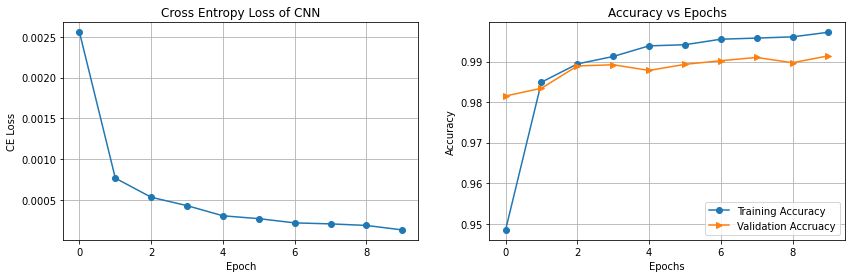

In [16]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
idx = [i for i in range(num_epochs)]
plt.plot(idx, train_losses, "-o")
plt.title("Cross Entropy Loss of CNN")
plt.ylabel("CE Loss")
plt.xlabel("Epoch")
plt.grid()
plt.subplot(1,2,2)
plt.plot(idx, train_accuracies, "-o", label="Training Accuracy")
plt.plot(idx, val_accuracies, "->", label="Validation Accruacy")
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()
plt.show()


In [17]:
# evaluate the test set
model.eval()
model.to(torch.device("cpu")) # no MPS support for inference time as of yet
with torch.no_grad():
    pred = model(mnist_test.data.unsqueeze(1) / 255.0)
    acc = (torch.argmax(pred, dim=1) == mnist_test.targets).sum().float() / mnist_test.targets.shape[0]
    print(f"Test accuracy = {acc*100:.4f}%.")


Test accuracy = 99.2500%.


### Smile Classification from Face Images Using CNN

In [19]:
image_path = "./datasets/"
celeb_train_dataset = torchvision.datasets.CelebA(image_path, split="train", target_type="attr", download=False)
celeb_val_dataset = torchvision.datasets.CelebA(image_path, split="valid", target_type="attr", download=False)
celeb_test_dataset = torchvision.datasets.CelebA(image_path, split="test", target_type="attr", download=False)
print(f"Train set instances: {len(celeb_train_dataset)}")
print(f"Validation set instances: {len(celeb_val_dataset)}")
print(f"Test set instances: {len(celeb_test_dataset)}")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

BadZipFile: File is not a zip file